In [38]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tokenizer = Tokenizer(char_level=True)

In [39]:
def dataset_preparation(fname):
    data = open(fname).read()

    # basic cleanup
    corpus = data.split("\n")

    # tokenization	
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    # create input sequences using list of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    # pad sequences 
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    # create predictors and label
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)

    return predictors, label, max_sequence_len, total_words

def create_model(predictors, label, max_sequence_len, total_words):
    index_train = np.array([True]*len(predictors))
    index_train[ np.arange(5,len(predictors),5)] = False
    index_test = ~index_train
    x_train = predictors[index_train]
    y_train = label[index_train]
    x_test = predictors[index_test]
    y_test = label[index_test]
    
    model = Sequential()
    model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
    model.add(LSTM(150, return_sequences = True))
    # model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

    #     model.fit(predictors, label, epochs=100, verbose=1, callbacks=[earlystop])
    history = model.fit(x_train, y_train, epochs=2, verbose=1, validation_data=(x_test, y_test), callbacks=[earlystop])
    print(model.summary())
    return history, model 

def generate_amino(protein, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([protein])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)

    next_amino = ""
    for amino, index in tokenizer.word_index.items():
        if index == predicted:
            next_amino = amino
            break
    protein += " " + next_amino
    return protein

In [41]:
# The full set
# fname = '/home/grzegorz/Desktop/CNN_pr2/data/pdb_seqres.txt'
# The small set only for testing
fname = '/home/grzegorz/Desktop/CNN_pr2/data/pdb_test.txt'

predictors, label, max_sequence_len, total_words = dataset_preparation(fname=fname)

In [16]:
history, model = create_model(predictors, label, max_sequence_len, total_words)

Train on 15060 samples, validate on 3764 samples
Epoch 1/2
15060/15060 [==============================] - 761s 51ms/step - loss: 2.8813 - acc: 0.0984 - val_loss: 2.8211 - val_acc: 0.1198
Epoch 2/2
15060/15060 [==============================] - 738s 49ms/step - loss: 2.6877 - acc: 0.1515 - val_loss: 2.4372 - val_acc: 0.2080
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 414, 10)           210       
_________________________________________________________________
lstm_3 (LSTM)                (None, 414, 150)          96600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2121      
Total params: 199,331
Trainable params: 199,331
Non-trainable params: 0
_________

In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
# model = load_model('my_model.h5')
print("Saved model to disk")

Saved model to disk


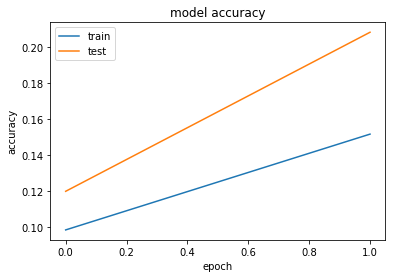

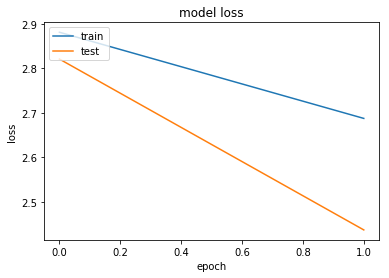

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.jpg')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.jpg')
plt.show()

In [ ]:
# perplexity = (step * 1.0 / model.input.epoch_size, np.exp(costs / iters)

In [42]:
protein = 'aab'
print(generate_amino(protein, max_sequence_len))

aab i
